# Capstone Project: Amazon Sales Prediction

## Research Question
**Can future sales volumes of Amazon products be accurately predicted using historical data and market trends to proactively optimize inventory levels?**

## Objectives
1.  **Sales Velocity Prediction (Regression):** Predict the exact number of units sold based on price, marketing spend, and stock levels.
2.  **Demand Classification (Classification):** Classify days as "High Demand" or "Low Demand" to trigger inventory alerts.

## Data Source
*   This notebook uses **Synthetic Data** mimicking the [Kaggle E-Commerce Sales Prediction Dataset](https://www.kaggle.com/datasets/nevildhinoja/e-commerce-sales-prediction-dataset).
*   **Key Features:** `Price`, `Discount`, `Marketing_Spend`, `Stock_Level`, `Weather`, `Promotion`.


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, classification_report, confusion_matrix

# Set style
sns.set(style="whitegrid")


In [2]:
# --- SYNTHETIC DATA GENERATION ---
# This cell generates a dataset matching the Nevil Dhinoja Kaggle schema so you can run this notebook immediately.

np.random.seed(42)
n_samples = 1000

data = {
    'Date': pd.date_range(start='2023-01-01', periods=n_samples, freq='D'),
    'Price': np.random.uniform(10, 100, n_samples).round(2),
    'Marketing_Spend': np.random.uniform(50, 5000, n_samples).round(2),
    'Discount': np.random.choice([0, 0.10, 0.20, 0.30], n_samples, p=[0.6, 0.2, 0.1, 0.1]),
    'Stock_Level': np.random.randint(0, 500, n_samples),
    'Weather': np.random.choice(['Sunny', 'Rainy', 'Cloudy'], n_samples),
    'Promotion': np.random.choice([0, 1], n_samples),
    'Product_Category': np.random.choice(['Electronics', 'Clothing', 'Home', 'Toys'], n_samples)
}

df = pd.DataFrame(data)

# Target Generation (Units Sold)
# Sales = Base + (Marketing * 0.1) - (Price * 2) + (Discount * 100) + Noise
base_demand = 50
df['Units_Sold'] = (
    base_demand + 
    (df['Marketing_Spend'] * 0.05) - 
    (df['Price'] * 1.5) + 
    (df['Discount'] * 200) + 
    (df['Promotion'] * 20) +
    np.random.normal(0, 10, n_samples)
).astype(int)

# Ensure no negative sales
df['Units_Sold'] = df['Units_Sold'].clip(lower=0)

# Create Classification Target: High Demand (Top 30% of sales)
threshold = df['Units_Sold'].quantile(0.70)
df['High_Demand'] = (df['Units_Sold'] > threshold).astype(int)

print(f"Dataset Shape: {df.shape}")
df.head()


Dataset Shape: (1000, 10)


,Date,Price,Marketing_Spend,Discount,Stock_Level,Weather,Promotion,Product_Category,Units_Sold,High_Demand
0,2023-01-01,43.71,966.41,0.0,370,Sunny,1,Electronics,51,0
1,2023-01-02,95.56,2732.41,0.0,312,Sunny,1,Electronics,57,0
2,2023-01-03,75.88,4371.08,0.3,484,Rainy,1,Clothing,224,1
3,2023-01-04,63.88,3674.51,0.0,327,Rainy,0,Clothing,127,0
4,2023-01-05,24.04,4042.48,0.0,6,Sunny,0,Toys,228,1


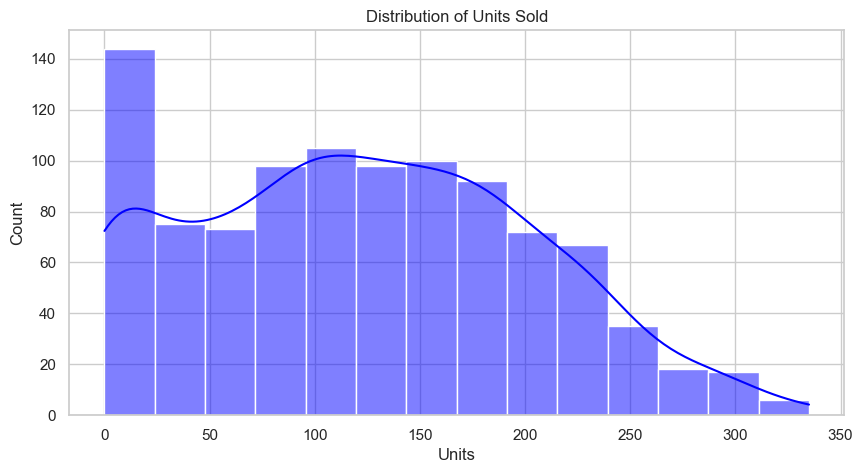

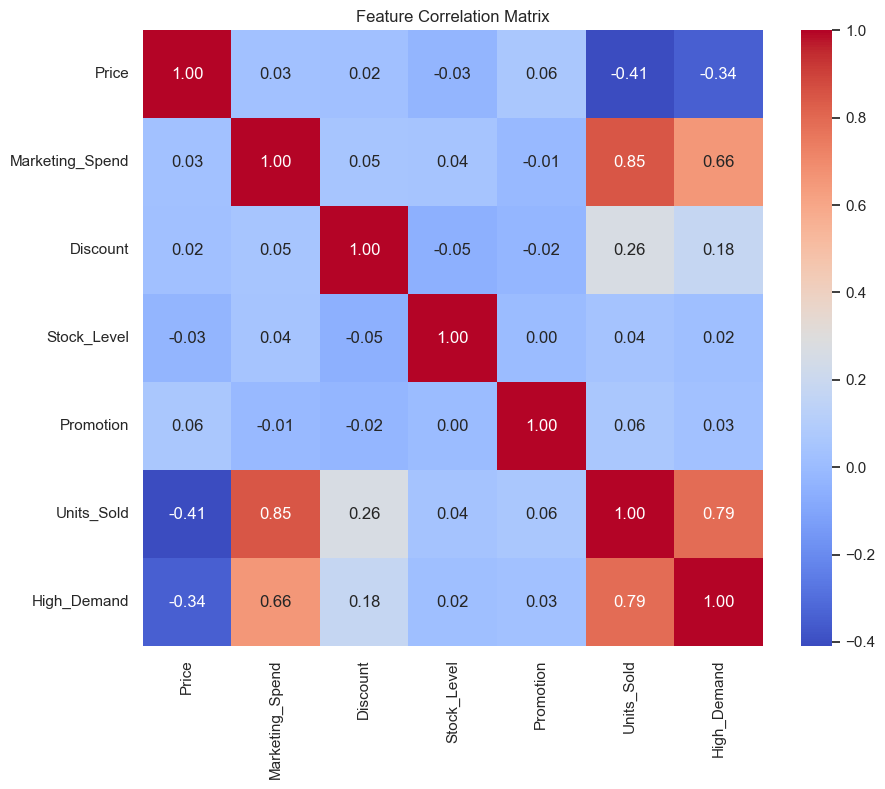

In [3]:
# --- EXPLORATORY DATA ANALYSIS (EDA) ---

# Distribution of Target
plt.figure(figsize=(10, 5))
sns.histplot(df['Units_Sold'], kde=True, color='blue')
plt.title('Distribution of Units Sold')
plt.xlabel('Units')
plt.show()

# Correlation Heatmap
plt.figure(figsize=(10, 8))
numeric_df = df.select_dtypes(include=[np.number])
sns.heatmap(numeric_df.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Feature Correlation Matrix')
plt.show()


In [4]:
# --- DATA PREPROCESSING ---

# Define Features
categorical_features = ['Weather', 'Product_Category']
numeric_features = ['Price', 'Marketing_Spend', 'Discount', 'Stock_Level', 'Promotion']

X = df.drop(['Date', 'Units_Sold', 'High_Demand'], axis=1)
y_reg = df['Units_Sold']   # Regression Target
y_clf = df['High_Demand']  # Classification Target

# Preprocessing Pipeline (extracted from Kaggle kernel)
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

print("Preprocessing Pipeline Defined.")


Preprocessing Pipeline Defined.


In [5]:
# --- TASK 1: REGRESSION (Predicting Sales Volume) ---

# Split Data
X_train, X_test, y_train, y_test = train_test_split(X, y_reg, test_size=0.2, random_state=42)

# Create Pipeline with Random Forest
model_reg = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(n_estimators=100, random_state=42))
])

# Train
print("Training Regression Model...")
model_reg.fit(X_train, y_train)

# Evaluate
y_pred_reg = model_reg.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred_reg))
r2 = r2_score(y_test, y_pred_reg)

print(f"Regression Results:")
print(f"  RMSE: {rmse:.2f} (Average prediction error in units)")
print(f"  R^2 Score: {r2:.4f}")

# Feature Importance
rf_model = model_reg.named_steps['regressor']
# Note: Extracting feature names from OneHotEncoder is tricky in pipeline, skipping plot for simplicity.


Training Regression Model...
Regression Results:
  RMSE: 14.28 (Average prediction error in units)
  R^2 Score: 0.9683


Training Classification Model...
Classification Results:
  Accuracy: 0.9800

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       141
           1       0.97      0.97      0.97        59

    accuracy                           0.98       200
   macro avg       0.98      0.98      0.98       200
weighted avg       0.98      0.98      0.98       200



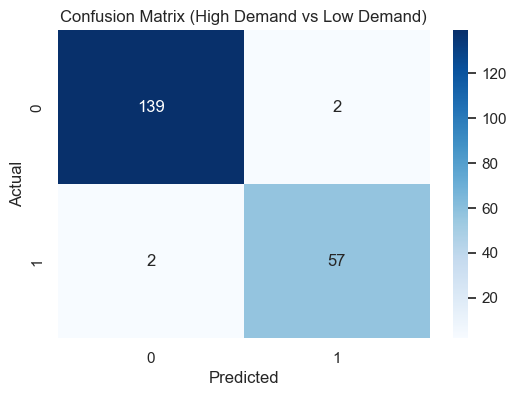

In [6]:
# --- TASK 2: CLASSIFICATION (Predicting High Demand) ---

# Split Data
X_train_c, X_test_c, y_train_c, y_test_c = train_test_split(X, y_clf, test_size=0.2, random_state=42)

# Create Pipeline with Logistic Regression
model_clf = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(max_iter=1000))
])

# Train
print("Training Classification Model...")
model_clf.fit(X_train_c, y_train_c)

# Evaluate
y_pred_clf = model_clf.predict(X_test_c)
acc = accuracy_score(y_test_c, y_pred_clf)

print(f"Classification Results:")
print(f"  Accuracy: {acc:.4f}")
print("\nClassification Report:")
print(classification_report(y_test_c, y_pred_clf))

# Confusion Matrix
cm = confusion_matrix(y_test_c, y_pred_clf)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix (High Demand vs Low Demand)')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()
